# Dollar Bar数量与动态阈值分析
1. 对固定阈值的bar进行分析（10M）
2. 设置动态阈值，与静态阈值生成的bar进行对比分析

In [8]:
# 基础依赖
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 字体设置（避免中文字体缺失警告）
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

In [9]:
def find_project_root(start: Path) -> Path:
    """向上寻找包含 pyproject.toml 的项目根目录"""
    current = start.resolve()
    for _ in range(10):
        if (current / 'pyproject.toml').exists():
            return current
        if current.parent == current:
            break
        current = current.parent
    # 回退到当前目录
    return start.resolve()

project_root = find_project_root(Path.cwd())
project_root

WindowsPath('E:/B/Economic&Finance/code/CryptoQuant')

In [10]:
def count_daily_bars(base_dir: Path) -> pd.DataFrame:
    """统计每天生成的 Dollar Bar 数量与成交额"""
    print("📊 开始统计Dollar Bar数量和成交额...")
    daily_counts = []
    
    # 遍历年份
    for year_dir in sorted(base_dir.glob('*')):
        if not year_dir.is_dir():
            continue
        year = year_dir.name
        print(f"  处理 {year} 年...")
        
        # 遍历月份
        for month_dir in sorted(year_dir.glob('*')):
            if not month_dir.is_dir():
                continue
            
            # 遍历每天的CSV文件
            for csv_file in sorted(month_dir.glob('*.csv')):
                try:
                    # 文件名示例: BTCUSDT_dollar_bars_10m_2020-01-01.csv
                    date_str = csv_file.stem.split('_')[-1]
                    date = pd.to_datetime(date_str)
                    
                    df = pd.read_csv(csv_file)
                    bar_count = len(df)
                    daily_volume = df['dollar_volume'].sum() if 'dollar_volume' in df.columns else 0
                    
                    daily_counts.append({
                        'date': date,
                        'bar_count': bar_count,
                        'daily_volume': daily_volume
                    })
                except Exception as e:
                    print(f"    ⚠️  处理 {csv_file.name} 时出错: {e}")
                    continue
    
    result = pd.DataFrame(daily_counts).sort_values('date').reset_index(drop=True)
    print(f"✅ 统计完成！共处理 {len(result)} 天的数据")
    return result


def plot_daily_bars(df: pd.DataFrame, output_dir: Path) -> None:
    """可视化每天的 Dollar Bar 数量（直接在 Notebook 显示）"""
    print("\n📈 开始绘图...")
    
    # 1. 完整时间序列图
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(df['date'], df['bar_count'], linewidth=0.8, alpha=0.7, color='steelblue')
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Number of Dollar Bars', fontsize=12)
    ax.set_title('Daily Dollar Bar Count (2020-2025)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 2. 按年份统计（箱线图）
    df['year'] = df['date'].dt.year
    fig, ax = plt.subplots(figsize=(12, 6))
    years = sorted(df['year'].unique())
    data_by_year = [df[df['year'] == year]['bar_count'].values for year in years]
    bp = ax.boxplot(data_by_year, tick_labels=years, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Number of Dollar Bars', fontsize=12)
    ax.set_title('Dollar Bar Distribution by Year (Boxplot)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 3. 月度平均值热力图
    df['month'] = df['date'].dt.month
    monthly_avg = df.groupby(['year', 'month'])['bar_count'].mean().unstack(fill_value=0)
    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(monthly_avg.values, cmap='YlOrRd', aspect='auto')
    ax.set_xticks(np.arange(len(monthly_avg.columns)))
    ax.set_yticks(np.arange(len(monthly_avg.index)))
    ax.set_xticklabels(monthly_avg.columns)
    ax.set_yticklabels(monthly_avg.index)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Year', fontsize=12)
    ax.set_title('Average Dollar Bar Count by Month (Heatmap)', fontsize=14, fontweight='bold')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Avg Bar Count', rotation=270, labelpad=20)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 4. 滚动平均图（7天和30天）
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(df['date'], df['bar_count'], linewidth=0.5, alpha=0.3, color='gray', label='Daily Count')
    ax.plot(df['date'], df['bar_count'].rolling(7).mean(), linewidth=1.5, color='orange', label='7-Day MA')
    ax.plot(df['date'], df['bar_count'].rolling(30).mean(), linewidth=2, color='red', label='30-Day MA')
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Number of Dollar Bars', fontsize=12)
    ax.set_title('Dollar Bar Count - Moving Average', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    print("\n📊 所有图表绘制完成！")


def print_statistics(df: pd.DataFrame) -> None:
    """打印统计信息"""
    print("\n" + "="*80)
    print("📊 Dollar Bar 统计摘要")
    print("="*80)
    print(f"\n时间范围: {df['date'].min().date()} 至 {df['date'].max().date()}")
    print(f"总天数: {len(df)} 天")
    
    print(f"\n整体统计 - Bar数量:")
    print(f"  总Bar数: {df['bar_count'].sum():,}")
    print(f"  平均每天: {df['bar_count'].mean():.1f} bars")
    print(f"  中位数: {df['bar_count'].median():.1f} bars")
    print(f"  标准差: {df['bar_count'].std():.1f}")
    print(f"  最小值: {df['bar_count'].min()} bars ({df.loc[df['bar_count'].idxmin(), 'date'].date()})")
    print(f"  最大值: {df['bar_count'].max()} bars ({df.loc[df['bar_count'].idxmax(), 'date'].date()})")
    
    print(f"\n整体统计 - 成交额:")
    print(f"  总成交额: ${df['daily_volume'].sum():,.2f}")
    print(f"  平均每天: ${df['daily_volume'].mean():,.2f}")
    print(f"  中位数: ${df['daily_volume'].median():,.2f}")
    print(f"  标准差: ${df['daily_volume'].std():,.2f}")
    print(f"  最小值: ${df['daily_volume'].min():,.2f} ({df.loc[df['daily_volume'].idxmin(), 'date'].date()})")
    print(f"  最大值: ${df['daily_volume'].max():,.2f} ({df.loc[df['daily_volume'].idxmax(), 'date'].date()})")
    
    print(f"\n按年份统计 - Bar数量:")
    df['year'] = df['date'].dt.year
    yearly_stats_bars = df.groupby('year')['bar_count'].agg(['count', 'sum', 'mean', 'std', 'min', 'max'])
    print(yearly_stats_bars.to_string())
    
    print(f"\n按年份统计 - 成交额:")
    yearly_stats_volume = df.groupby('year')['daily_volume'].agg(['sum', 'mean', 'std', 'min', 'max'])
    yearly_stats_volume.columns = ['total_volume', 'avg_volume', 'std_volume', 'min_volume', 'max_volume']
    print(yearly_stats_volume.to_string())
    
    print("\n" + "="*80)

In [11]:
def calculate_dynamic_bars(df: pd.DataFrame, n_target: int = 200, ema_span: int = 30) -> pd.DataFrame:
    """计算基于动态阈值的 Bar 数量"""
    print(f"📊 开始计算动态阈值 (N_target={n_target}, EMA_span={ema_span})...")
    df = df.copy()
    df['volume_ema'] = df['daily_volume'].ewm(span=ema_span, adjust=False).mean()
    df['volume_ema_prev'] = df['volume_ema'].shift(1)
    df['dynamic_threshold'] = df['volume_ema_prev'] / n_target
    df['dynamic_bar_count'] = df['daily_volume'] / df['dynamic_threshold']
    
    mask = df['dynamic_threshold'].isna()
    df.loc[mask, 'dynamic_threshold'] = df.loc[mask, 'daily_volume'] / n_target
    df.loc[mask, 'dynamic_bar_count'] = n_target
    
    df['bar_diff'] = df['dynamic_bar_count'] - df['bar_count']
    df['bar_diff_pct'] = (df['dynamic_bar_count'] - df['bar_count']) / df['bar_count'] * 100
    print("✅ 计算完成！")
    return df


def print_comparison_stats(df: pd.DataFrame) -> None:
    """打印对比统计信息"""
    print("\n" + "="*80)
    print("📊 动态阈值 vs 原始阈值 对比分析")
    print("="*80)
    
    print("\n原始Bar数量统计:")
    print(f"  平均: {df['bar_count'].mean():.1f} bars/day")
    print(f"  中位数: {df['bar_count'].median():.1f} bars/day")
    print(f"  标准差: {df['bar_count'].std():.1f}")
    print(f"  变异系数: {df['bar_count'].std() / df['bar_count'].mean():.2%}")
    print(f"  范围: [{df['bar_count'].min()}, {df['bar_count'].max()}]")
    
    print("\n动态阈值Bar数量统计:")
    print(f"  平均: {df['dynamic_bar_count'].mean():.1f} bars/day")
    print(f"  中位数: {df['dynamic_bar_count'].median():.1f} bars/day")
    print(f"  标准差: {df['dynamic_bar_count'].std():.1f}")
    print(f"  变异系数: {df['dynamic_bar_count'].std() / df['dynamic_bar_count'].mean():.2%}")
    print(f"  范围: [{df['dynamic_bar_count'].min():.1f}, {df['dynamic_bar_count'].max():.1f}]")
    
    print("\n改进效果:")
    print(f"  标准差降低: {(df['bar_count'].std() - df['dynamic_bar_count'].std()):.1f}")
    print(f"  标准差降低率: {(1 - df['dynamic_bar_count'].std() / df['bar_count'].std()):.2%}")
    print(f"  变异系数改善: {(df['bar_count'].std()/df['bar_count'].mean() - df['dynamic_bar_count'].std()/df['dynamic_bar_count'].mean()):.2%}")
    
    print("\n按年份对比:")
    df['year'] = pd.to_datetime(df['date']).dt.year
    yearly_comparison = df.groupby('year').agg({
        'bar_count': ['mean', 'std'],
        'dynamic_bar_count': ['mean', 'std']
    }).round(1)
    yearly_comparison.columns = ['原始_均值', '原始_标准差', '动态_均值', '动态_标准差']
    print(yearly_comparison.to_string())
    print("\n" + "="*80)


def plot_comparison(df: pd.DataFrame, output_dir: Path) -> None:
    """绘制对比图（直接在 Notebook 显示）"""
    print("\n📈 开始绘制对比图...")
    df['date'] = pd.to_datetime(df['date'])
    
    # 1. 时间序列对比图
    fig, axes = plt.subplots(3, 1, figsize=(20, 12))
    ax1 = axes[0]
    ax1.plot(df['date'], df['bar_count'], label='Original Bar Count', linewidth=1, alpha=0.7, color='steelblue')
    ax1.plot(df['date'], df['dynamic_bar_count'], label='Dynamic Threshold Bar Count', linewidth=1, alpha=0.7, color='orange')
    ax1.axhline(y=200, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Target (200)')
    ax1.set_ylabel('Number of Bars per Day', fontsize=11)
    ax1.set_title('Daily Dollar Bar Count: Original vs Dynamic Threshold', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    colors = ['green' if x > 0 else 'red' for x in df['bar_diff']]
    ax2.bar(df['date'], df['bar_diff'], color=colors, alpha=0.5, width=1)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax2.set_ylabel('Difference (Dynamic - Original)', fontsize=11)
    ax2.set_title('Bar Count Difference', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    ax3 = axes[2]
    ax3.plot(df['date'], df['dynamic_threshold'] / 1e6, linewidth=1, alpha=0.7, color='purple')
    ax3.set_xlabel('Date', fontsize=11)
    ax3.set_ylabel('Dynamic Threshold (Million USD)', fontsize=11)
    ax3.set_title('Dynamic Threshold Evolution', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 2. 分布对比图（直方图）
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ax1 = axes[0]
    ax1.hist(df['bar_count'], bins=50, alpha=0.6, color='steelblue',
             label=f'Original (std={df["bar_count"].std():.1f})', edgecolor='black')
    ax1.axvline(df['bar_count'].mean(), color='blue', linestyle='--', linewidth=2,
                label=f'Mean={df["bar_count"].mean():.1f}')
    ax1.axvline(200, color='red', linestyle='--', linewidth=2, label='Target=200')
    ax1.set_xlabel('Bars per Day', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title('Original Bar Count Distribution', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    
    ax2 = axes[1]
    ax2.hist(df['dynamic_bar_count'], bins=50, alpha=0.6, color='orange',
             label=f'Dynamic (std={df["dynamic_bar_count"].std():.1f})', edgecolor='black')
    ax2.axvline(df['dynamic_bar_count'].mean(), color='darkorange', linestyle='--', linewidth=2,
                label=f'Mean={df["dynamic_bar_count"].mean():.1f}')
    ax2.axvline(200, color='red', linestyle='--', linewidth=2, label='Target=200')
    ax2.set_xlabel('Bars per Day', fontsize=11)
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.set_title('Dynamic Threshold Bar Count Distribution', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 3. 箱线图对比
    fig, ax = plt.subplots(figsize=(10, 8))
    data_to_plot = [df['bar_count'], df['dynamic_bar_count']]
    labels = ['Original', 'Dynamic Threshold']
    bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True, widths=0.6)
    colors = ['steelblue', 'orange']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.axhline(y=200, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target (200)')
    ax.set_ylabel('Bars per Day', fontsize=12)
    ax.set_title('Bar Count Distribution Comparison (Boxplot)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    stats_text = f'Original: μ={df["bar_count"].mean():.1f}, σ={df["bar_count"].std():.1f}\n'
    stats_text += f'Dynamic: μ={df["dynamic_bar_count"].mean():.1f}, σ={df["dynamic_bar_count"].std():.1f}\n'
    stats_text += f'Std Reduction: {(1 - df["dynamic_bar_count"].std()/df["bar_count"].std()):.1%}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # 4. 滚动统计对比
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    window = 30
    ax1 = axes[0]
    ax1.plot(df['date'], df['bar_count'].rolling(window).mean(),
             label=f'Original {window}D MA', linewidth=2, alpha=0.8, color='steelblue')
    ax1.plot(df['date'], df['dynamic_bar_count'].rolling(window).mean(),
             label=f'Dynamic {window}D MA', linewidth=2, alpha=0.8, color='orange')
    ax1.axhline(y=200, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Target (200)')
    ax1.set_ylabel('Bars per Day (30D MA)', fontsize=11)
    ax1.set_title('30-Day Moving Average Comparison', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    ax2.plot(df['date'], df['bar_count'].rolling(window).std(),
             label=f'Original {window}D Std', linewidth=2, alpha=0.8, color='steelblue')
    ax2.plot(df['date'], df['dynamic_bar_count'].rolling(window).std(),
             label=f'Dynamic {window}D Std', linewidth=2, alpha=0.8, color='orange')
    ax2.set_xlabel('Date', fontsize=11)
    ax2.set_ylabel('Standard Deviation (30D)', fontsize=11)
    ax2.set_title('30-Day Rolling Standard Deviation', fontsize=13, fontweight='bold')
    ax2.legend(loc='upper left', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    print("\n📊 所有对比图表绘制完成！")

📊 开始统计Dollar Bar数量和成交额...
  处理 2020 年...
  处理 2021 年...
  处理 2022 年...
  处理 2023 年...
  处理 2024 年...
  处理 2025 年...
✅ 统计完成！共处理 2192 天的数据

📊 Dollar Bar 统计摘要

时间范围: 2020-01-01 至 2025-12-31
总天数: 2192 天

整体统计 - Bar数量:
  总Bar数: 515,440
  平均每天: 235.1 bars
  中位数: 182.0 bars
  标准差: 198.3
  最小值: 12 bars (2020-01-01)
  最大值: 1744 bars (2023-03-14)

整体统计 - 成交额:
  总成交额: $5,166,798,994,625.24
  平均每天: $2,357,116,329.66
  中位数: $1,824,777,100.94
  标准差: $1,986,608,334.04
  最小值: $120,014,419.25 (2020-01-01)
  最大值: $17,459,473,730.50 (2023-03-14)

按年份统计 - Bar数量:
      count     sum        mean         std  min   max
year                                                  
2020    366   28426   77.666667   55.764901   12   418
2021    365  114967  314.978082  146.327551   97  1341
2022    365  119578  327.610959  212.767161   61  1473
2023    365   91724  251.298630  295.161385   25  1744
2024    366   84538  230.978142  152.244251   45  1099
2025    365   76207  208.786301  125.363092   34   937

按年份统计 - 成交

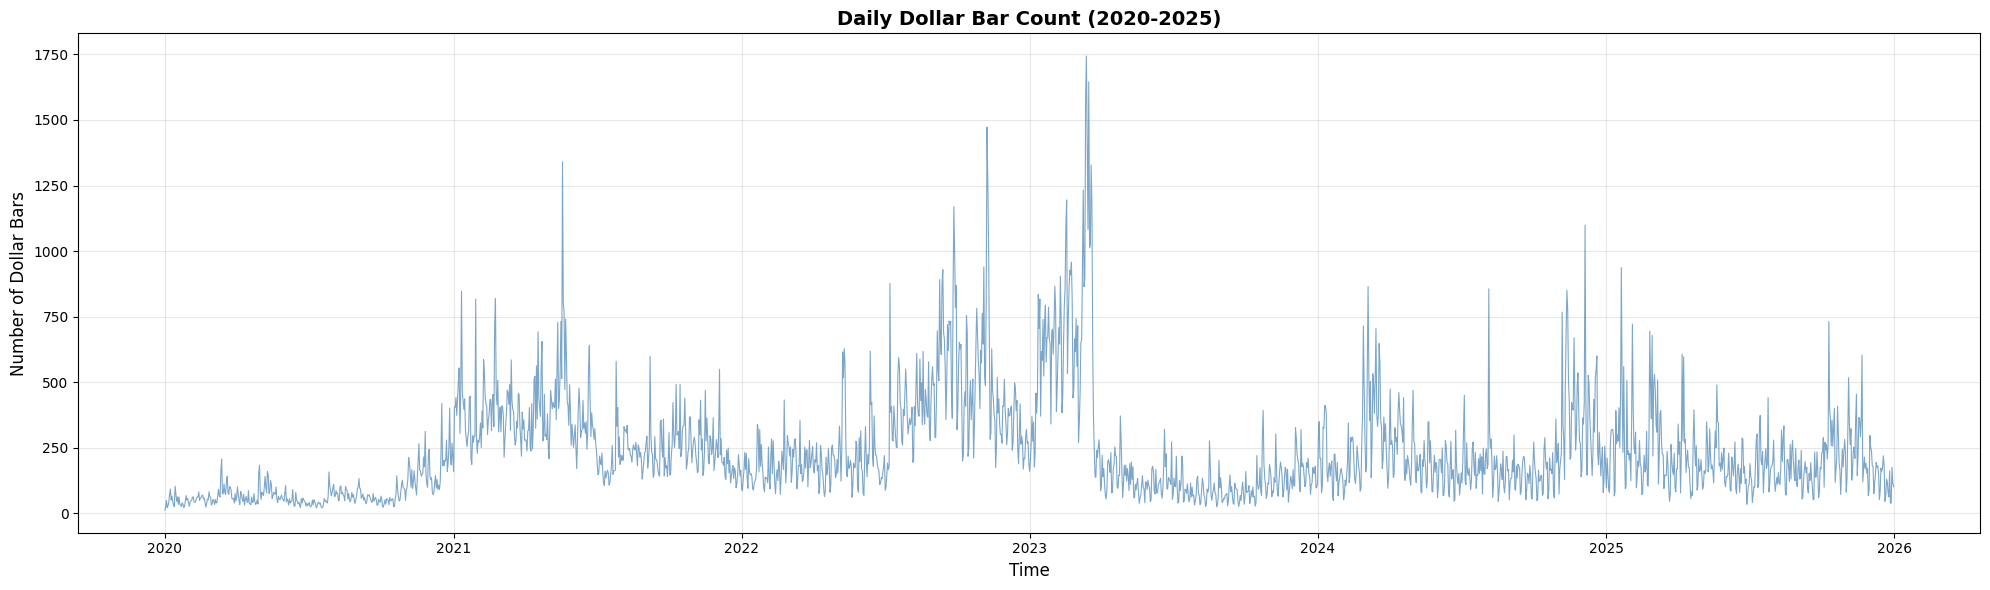

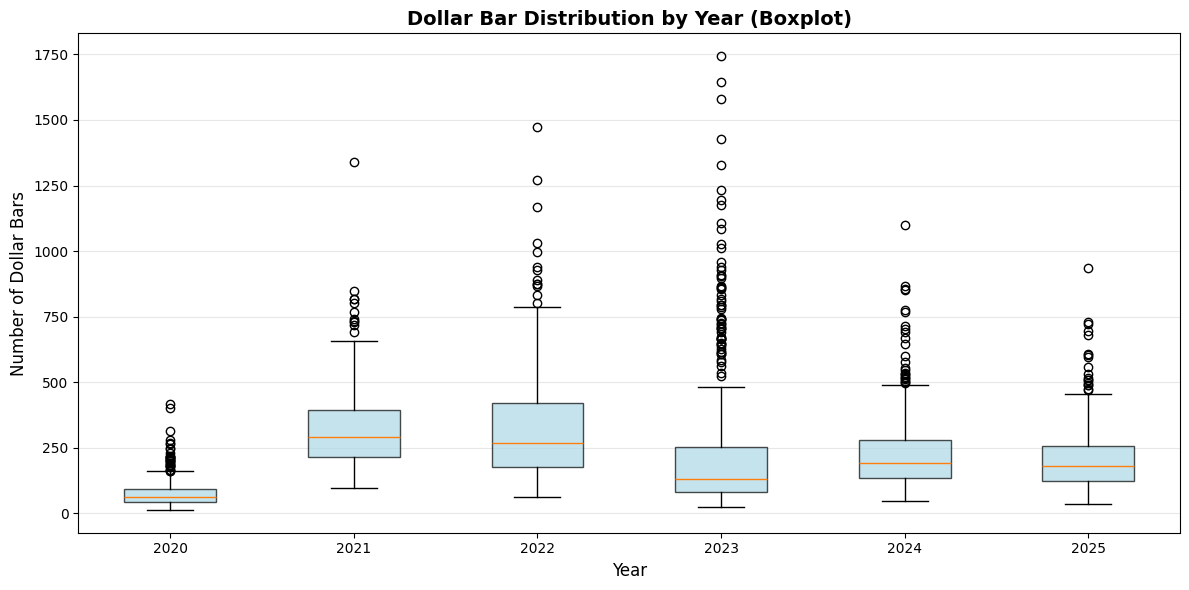

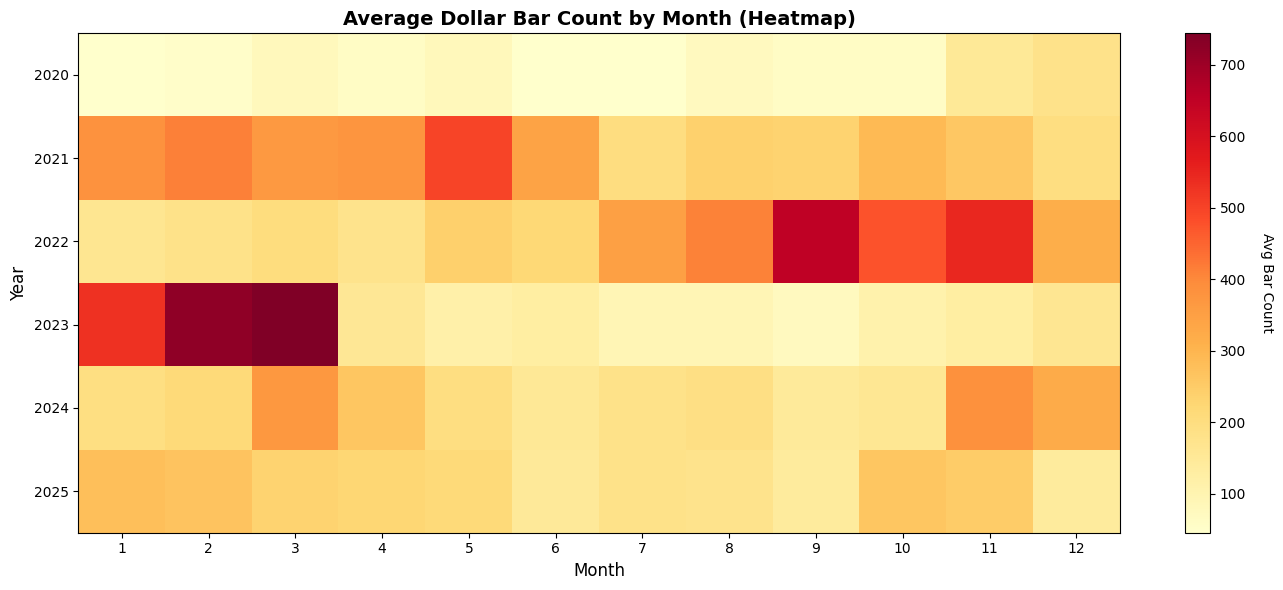

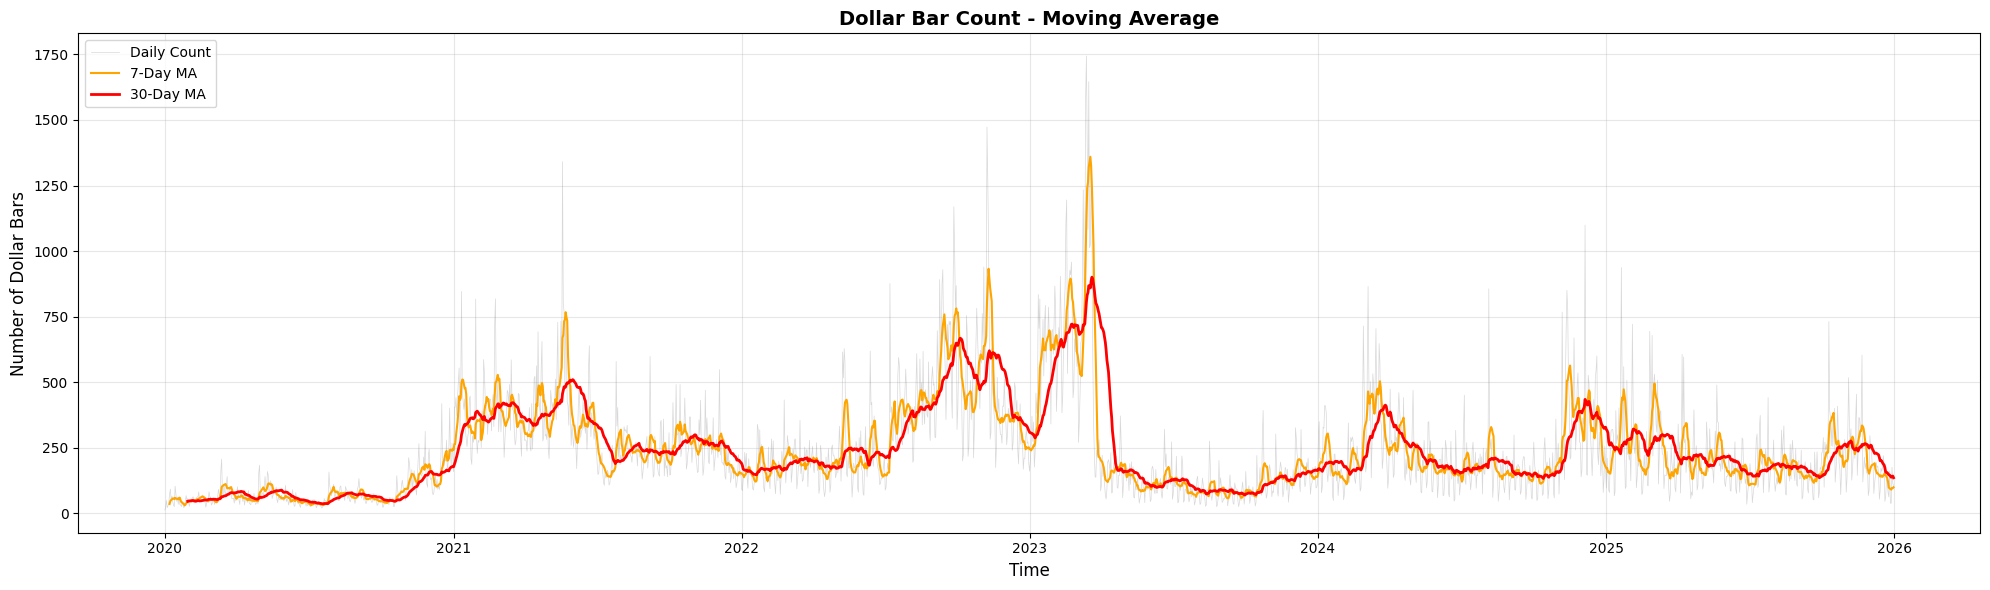


📊 所有图表绘制完成！

💾 统计数据已保存至: E:\B\Economic&Finance\code\CryptoQuant\reports\dollar_bar_analysis\daily_bar_counts_and_volume.csv
📊 开始计算动态阈值 (N_target=200, EMA_span=7)...
✅ 计算完成！

📊 动态阈值 vs 原始阈值 对比分析

原始Bar数量统计:
  平均: 235.1 bars/day
  中位数: 182.0 bars/day
  标准差: 198.3
  变异系数: 84.34%
  范围: [12, 1744]

动态阈值Bar数量统计:
  平均: 206.1 bars/day
  中位数: 190.7 bars/day
  标准差: 97.7
  变异系数: 47.43%
  范围: [38.3, 1083.0]

改进效果:
  标准差降低: 100.6
  标准差降低率: 50.72%
  变异系数改善: 36.92%

按年份对比:
      原始_均值  原始_标准差  动态_均值  动态_标准差
year                              
2020   77.7    55.8  211.2    92.6
2021  315.0   146.3  202.2    72.8
2022  327.6   212.8  205.5    92.1
2023  251.3   295.2  204.7   105.2
2024  231.0   152.2  207.9   112.0
2025  208.8   125.4  205.1   106.9


📈 开始绘制对比图...


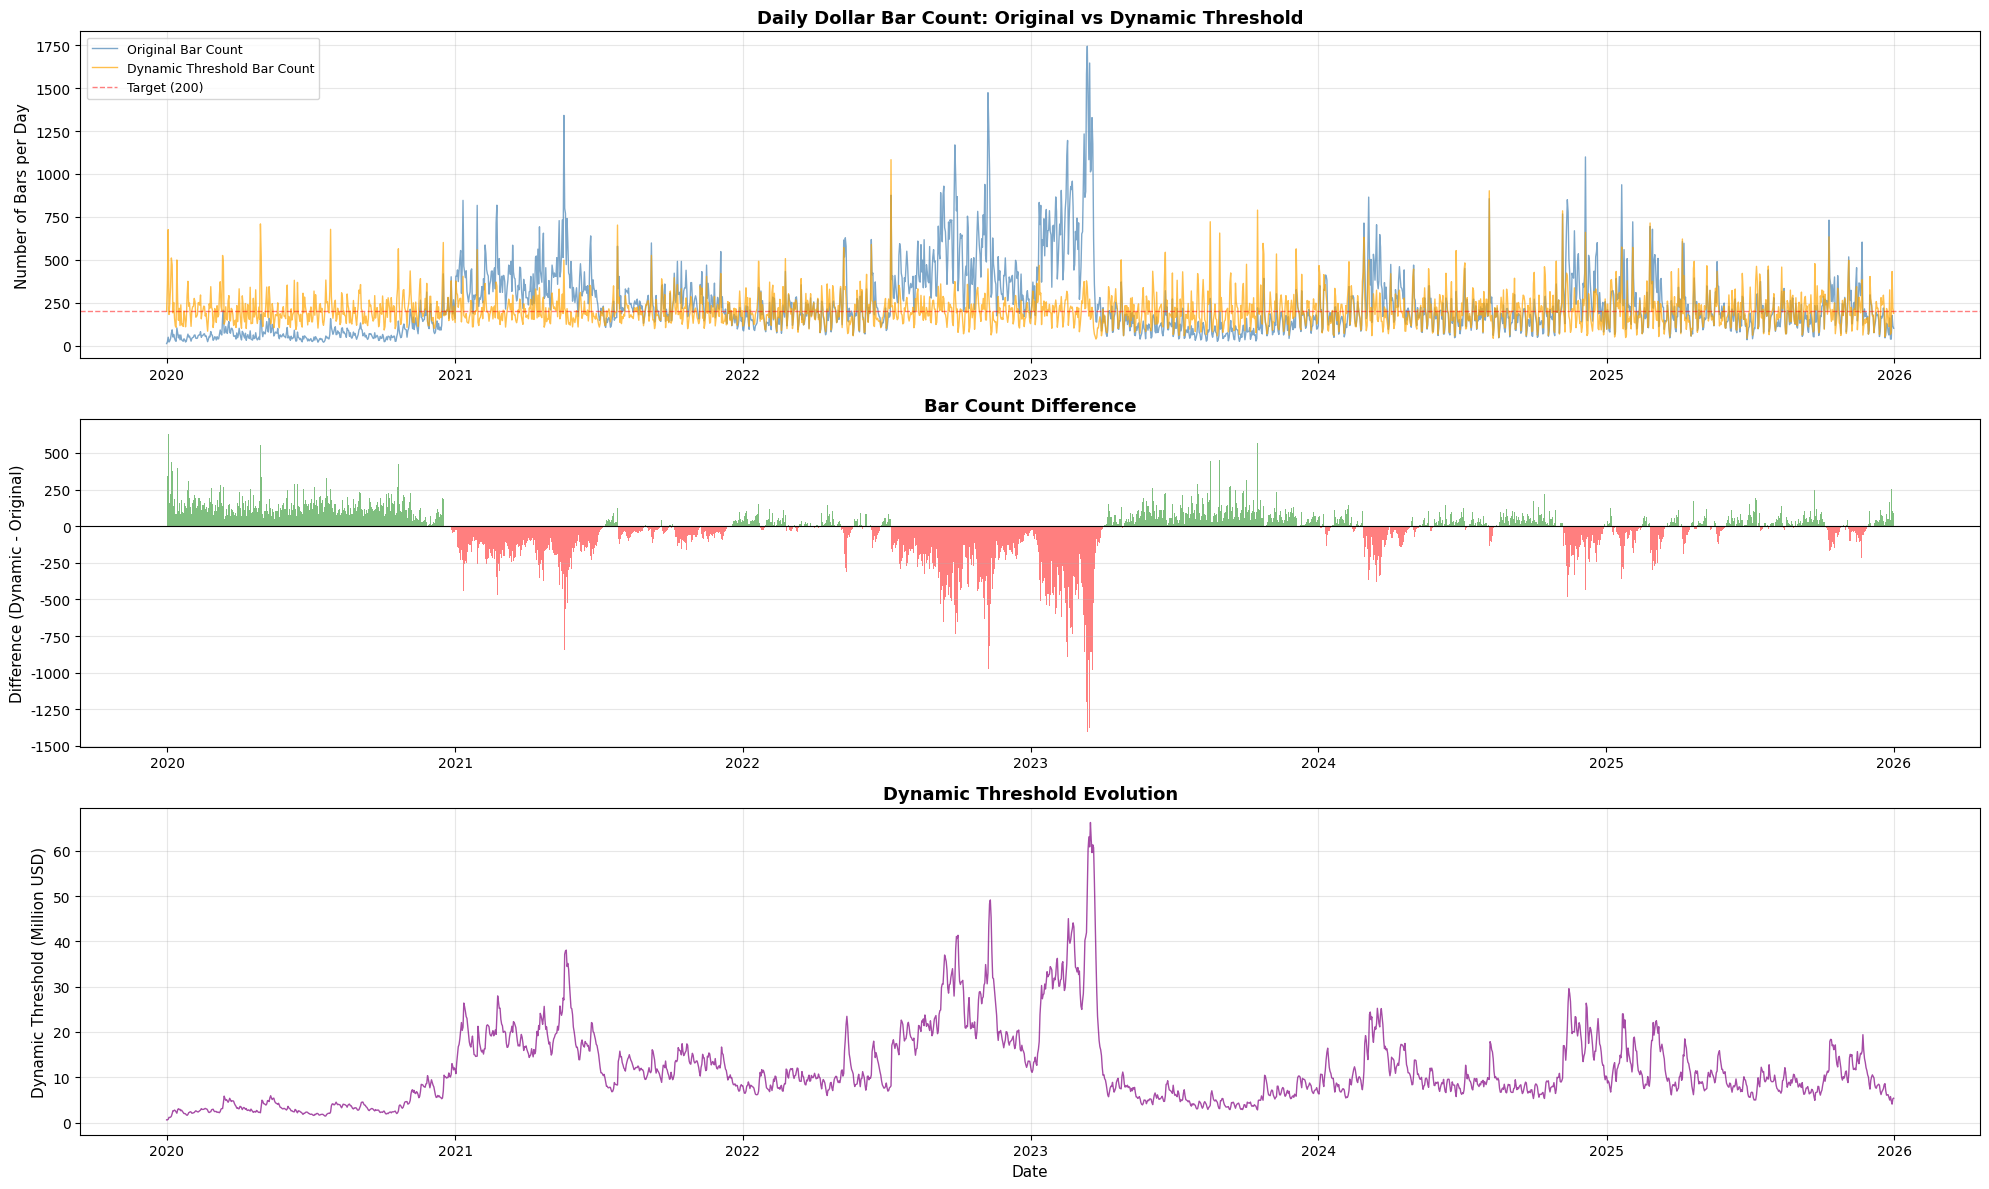

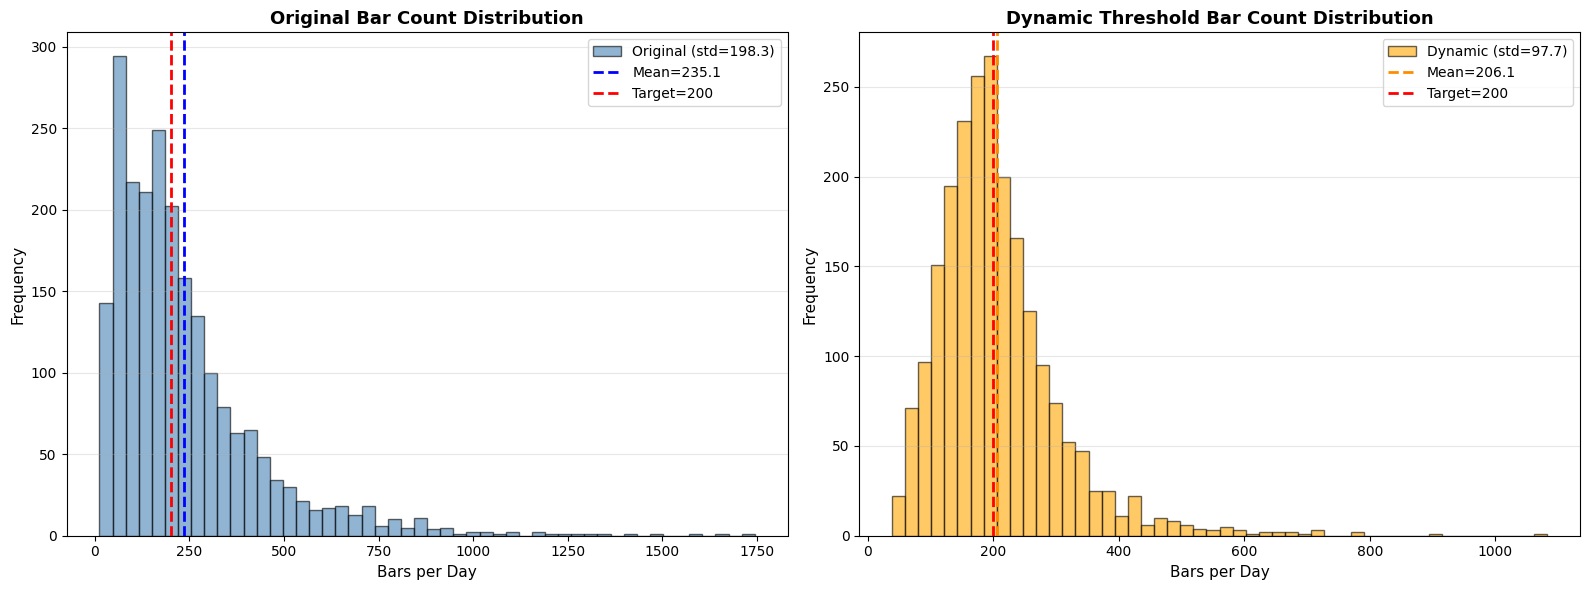

C:\Users\Ithai\AppData\Local\Temp\ipykernel_34160\675289412.py:125: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True, widths=0.6)


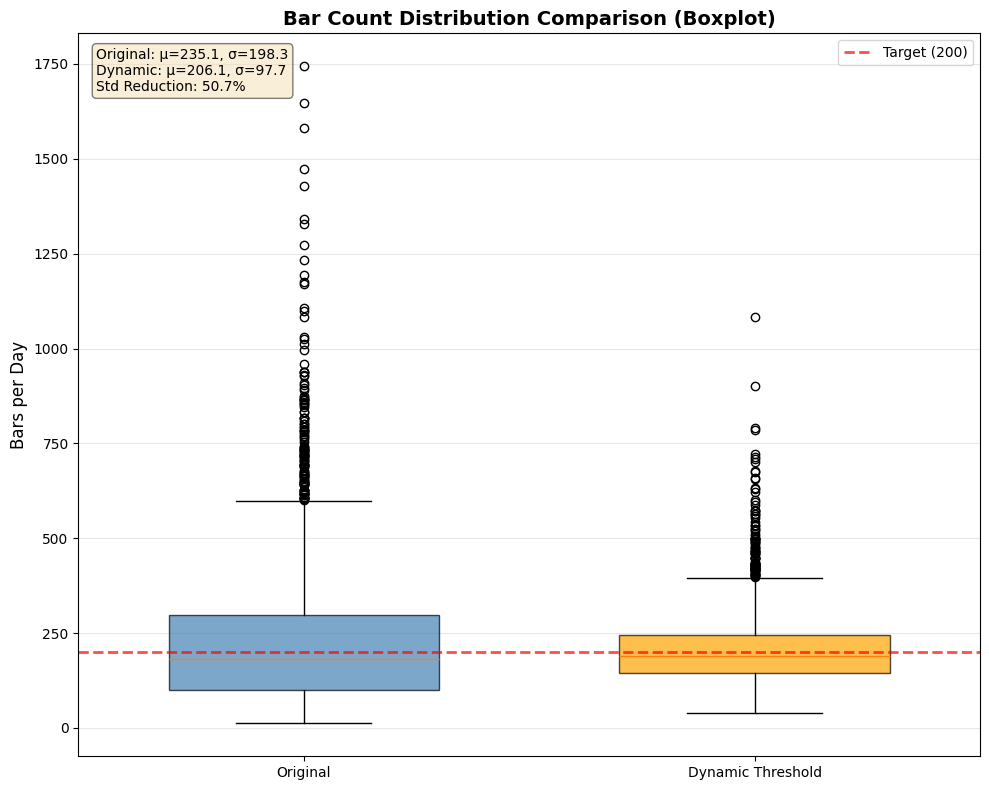

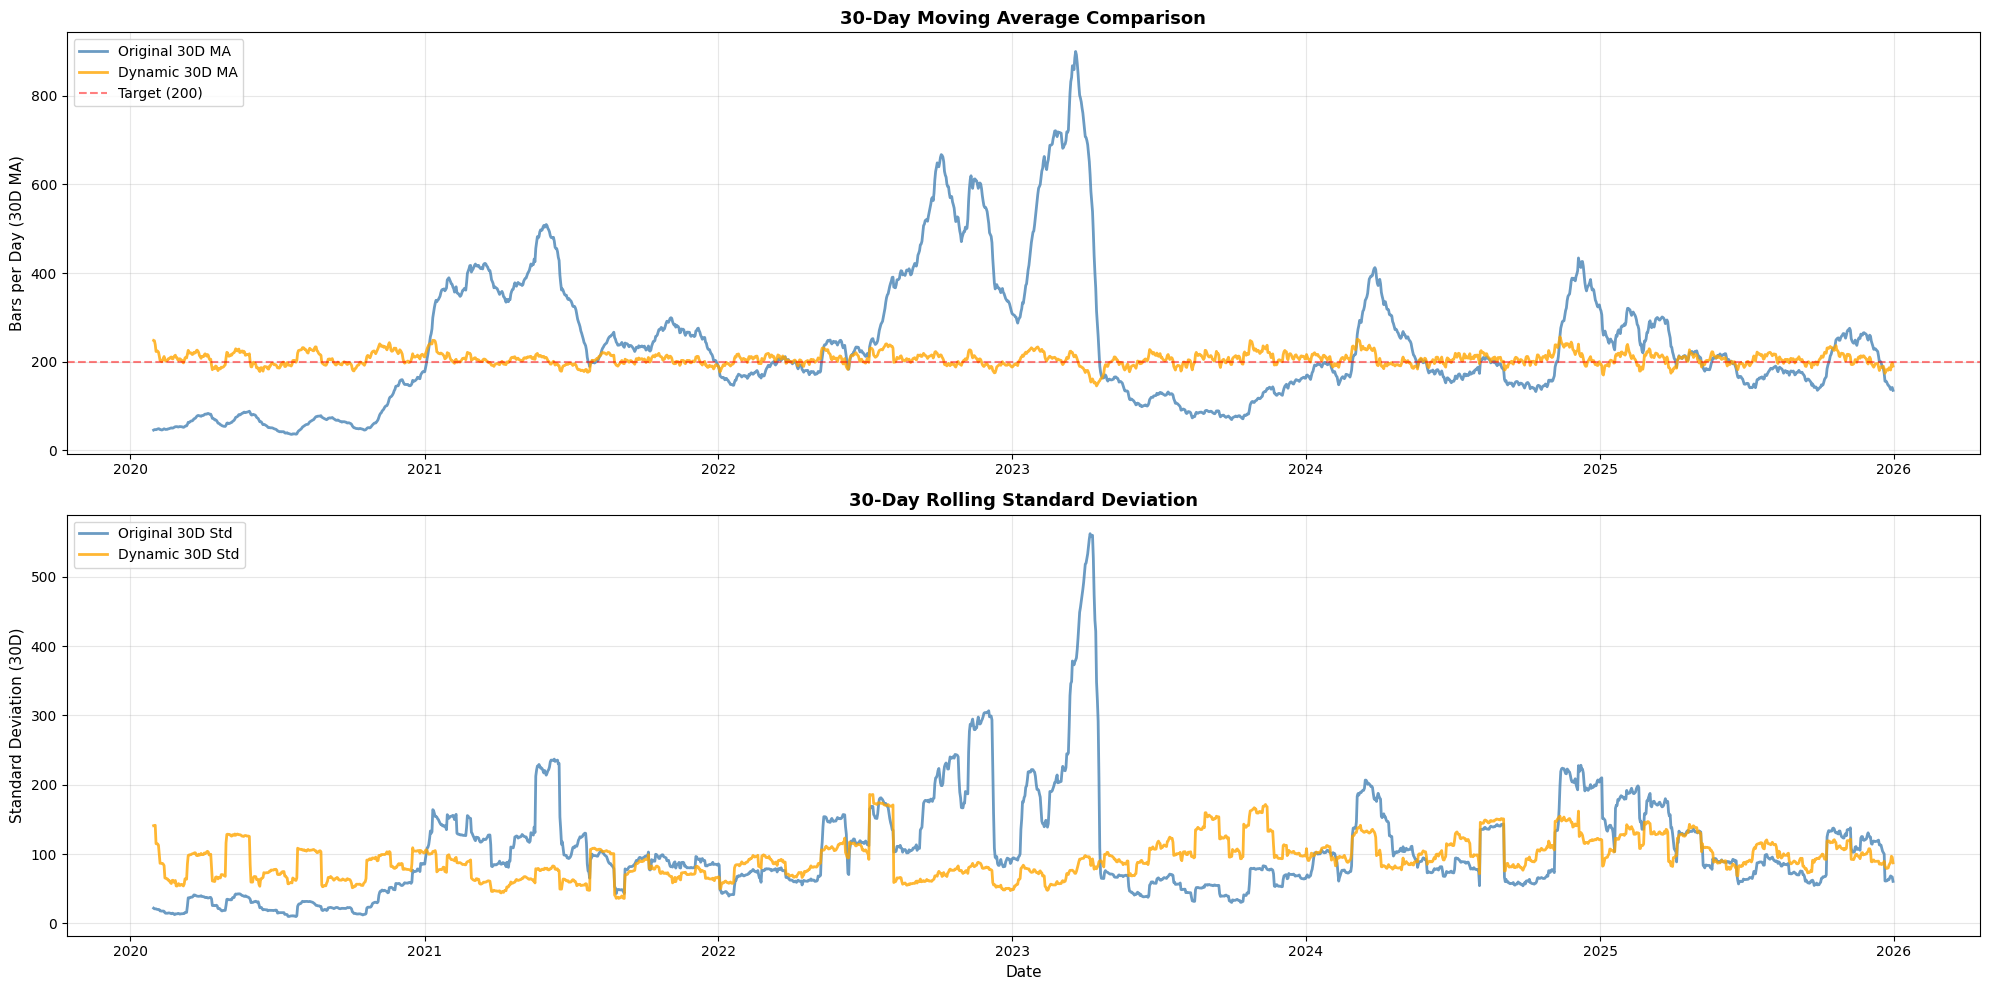


📊 所有对比图表绘制完成！

💾 动态阈值分析结果已保存至: E:\B\Economic&Finance\code\CryptoQuant\reports\dollar_bar_analysis\dynamic_threshold_analysis.csv

✅ 分析完成！结果保存在: E:\B\Economic&Finance\code\CryptoQuant\reports\dollar_bar_analysis


In [13]:
# =========================
# 运行分析（按需修改参数）
# =========================
data_dir = project_root / 'data' / 'preprocess_data' / 'dollar_bars' / 'BTCUSDT'
output_dir = project_root / 'reports' / 'dollar_bar_analysis'
output_dir.mkdir(parents=True, exist_ok=True)

# 1) 统计每天的 Bar 数量与成交额
if not data_dir.exists():
    raise FileNotFoundError(f"数据目录不存在: {data_dir}")

daily_df = count_daily_bars(data_dir)
print_statistics(daily_df)
plot_daily_bars(daily_df, output_dir)

# 保存统计结果
daily_csv = output_dir / 'daily_bar_counts_and_volume.csv'
daily_df.to_csv(daily_csv, index=False, encoding='utf-8')
print(f"\n💾 统计数据已保存至: {daily_csv}")

# 2) 动态阈值分析
df_result = calculate_dynamic_bars(daily_df, n_target=200, ema_span=7)
print_comparison_stats(df_result)
plot_comparison(df_result, output_dir)

# 保存动态阈值结果
dynamic_csv = output_dir / 'dynamic_threshold_analysis.csv'
df_result.to_csv(dynamic_csv, index=False, encoding='utf-8')
print(f"\n💾 动态阈值分析结果已保存至: {dynamic_csv}")

print(f"\n✅ 分析完成！结果保存在: {output_dir}")